# Comparison to the Water Budget
We compare the changes of our reconstructed water storage anomalies to the water balance, derived from ERA5.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # noqa
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.regions import basins
from deeprec.utils import ROOT_DIR

# Register dask progress bar
ProgressBar(minimum=5).register()

In [2]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/si"

## Data Loading

For preprocessing, see the corresponding notebook in `20-si-plots/water-budget-closure-processing.ipynb`.

In [3]:
twsc_path = ROOT_DIR / "data/evaluations/twsc_basin-scale.zarr"
twsc = xr.open_zarr(twsc_path)

## Analysis

Define evaluation models and water balance target:

In [4]:
vars_verbose = {
    "ours_era-rdcd": "DeepRec, 4×ERA5",
    "ours_era": "DeepRec, 14×ERA5",
    "ours_wghm-era": "DeepRec, WGHM+14×ERA5",
    "gap": "WGHM",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "li_csr_full": "Li's CSR Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "csr": "CSR (GRACE)",
}
bdgt_name = "era5_smooth"
grace_name = "csr"
eval_names = vars_verbose.keys()

In [5]:
# Drop all time steps where one variable is NaN
twsc_post = twsc.where(twsc.dr.time_notnull("region"), drop=True)
twsc_post

<xarray.Dataset> Size: 1MB
Dimensions:                (region: 72, time: 192)
Coordinates:
  * region                 (region) object 576B 'Amazon' 'Congo' ... 'Ural'
  * time                   (time) datetime64[ns] 2kB 2002-05-01 ... 2019-06-01
Data variables:
    csr                    (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    era5                   (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    era5_smooth            (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    gap                    (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    humphrey_gsfc_detrend  (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    li_csr_full            (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    ours_era               (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    ours_era-rdcd          (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    ours_wghm-era          (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    yin_csr_full           (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>

In [6]:
bdgt_post = twsc_post[bdgt_name]
eval_post = twsc_post[eval_names].to_dataarray("model")

In [7]:
plot_kwargs = dict(
    col_wrap=2,
    coastlines=True,
    gridlines=True,
    cmap="PiYG",
    vmin=-1,
    vmax=1,
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.8, pad=0.03, label="NSE"),
    rasterized=True,
    coastlines_kwargs=dict(rasterized=True),
    figsize=(6, 8.25),
)
basinlines_kwargs = dict(
    edgecolor="black", linewidth=0.5, facecolor="None", rasterized=True, zorder=3.0
)
title_kwargs = dict(fontsize=16, weight="bold")

In [8]:
# Create a spatial dummy array for the .dr.projplot_basins(() function
STEP_DEG = 0.5
lats = np.arange(-89.75, 89.75 + STEP_DEG, STEP_DEG)
lons = np.arange(-179.75, 179.75 + STEP_DEG, STEP_DEG)
models = eval_post.model.values

ones = np.ones([len(models), len(lats), len(lons)])

spatial_dummy_post = xr.DataArray(
    ones, coords={"model": models, "lat": lats, "lon": lons}
)


### NSE during GRACE era

In [9]:
da_post_nse = metrics.nse(bdgt_post, eval_post, dim="time").compute()
da_post_nse.attrs["standard_name"] = "NSE"
da_post_nse.attrs["unit"] = "-"

c:\Users\luisg\Repositories\deeprec\.venv\Lib\site-packages\xarray\plot\facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


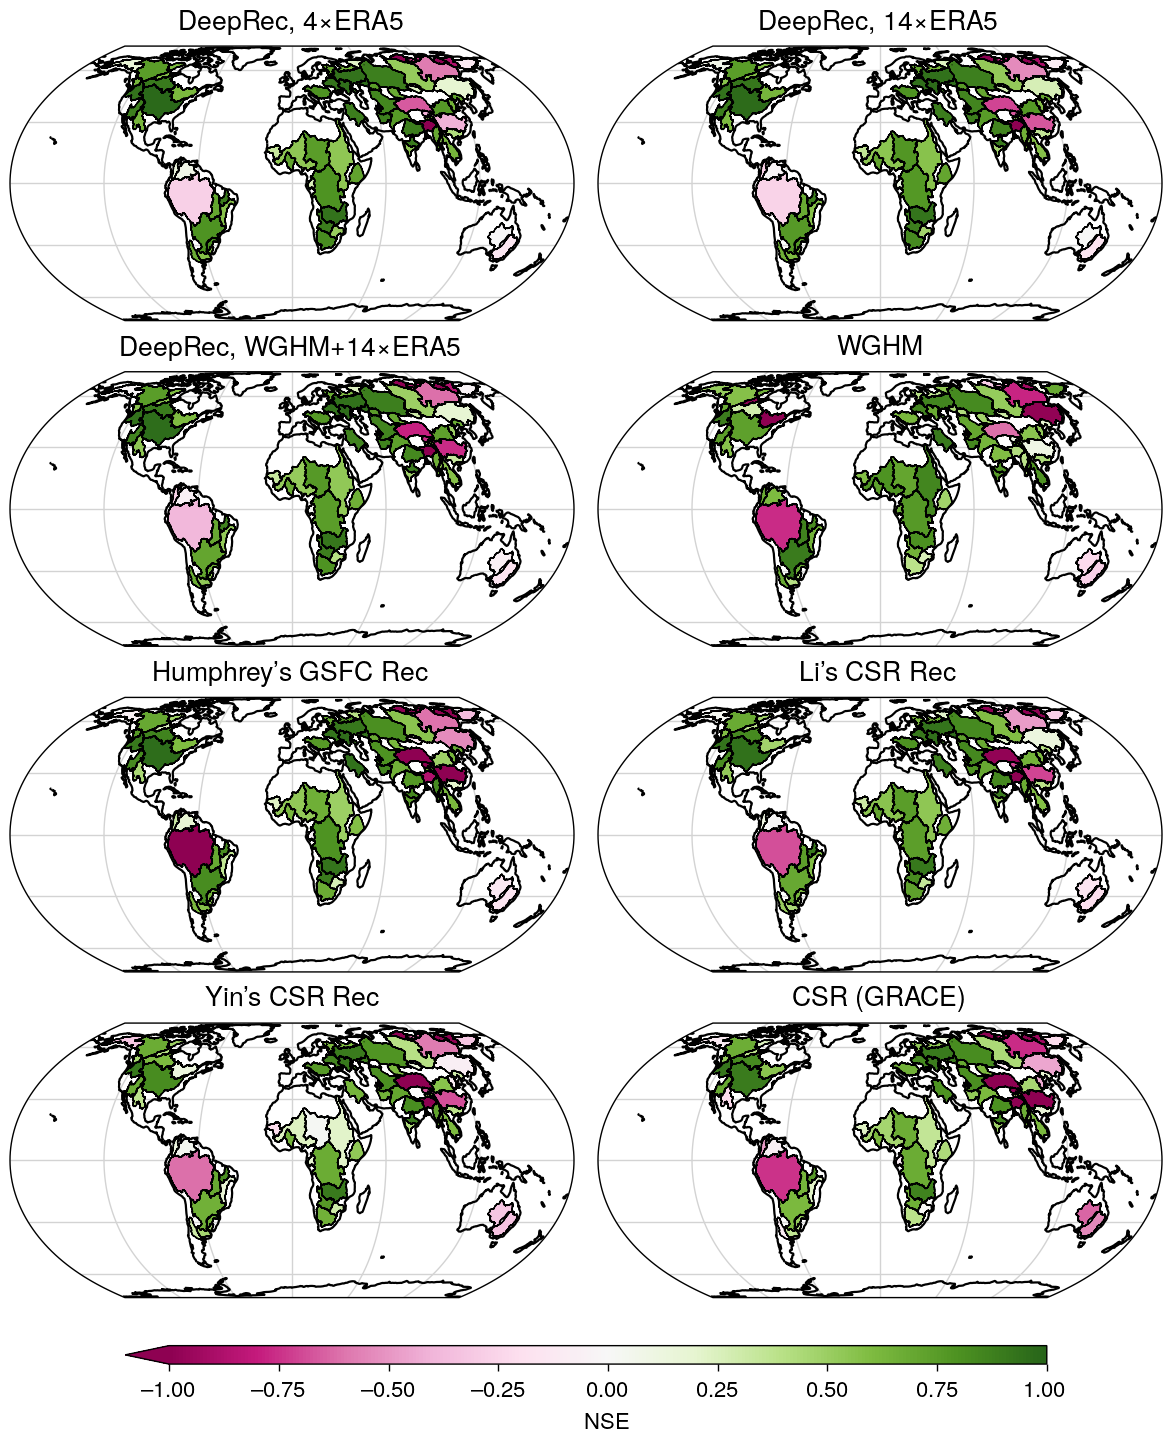

In [10]:
p = da_post_nse.dr.projplot_basins(
    spatial_obj=spatial_dummy_post, col="model", **plot_kwargs
)

basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, da_post_nse.model.values):
    basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)
    ax.set(title=vars_verbose[model])

p.fig.savefig(FIGURE_DIR / "waterbudget_2002-2019_nse.pdf", backend="pgf")

### NSE before the GRACE era

In [11]:
twsc_pre = twsc.sel(time=slice("1980", "2002-03"))

bdgt_pre = twsc_pre[bdgt_name]
eval_pre = twsc_pre[eval_names].drop_vars(grace_name).to_dataarray("model")

spatial_dummy_pre = spatial_dummy_post.drop_sel(model=grace_name)

In [12]:
da_pre_nse = metrics.nse(bdgt_pre, eval_pre, dim="time").compute()
da_pre_nse.attrs["standard_name"] = "NSE"
da_pre_nse.attrs["unit"] = "-"

c:\Users\luisg\Repositories\deeprec\.venv\Lib\site-packages\xarray\plot\facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


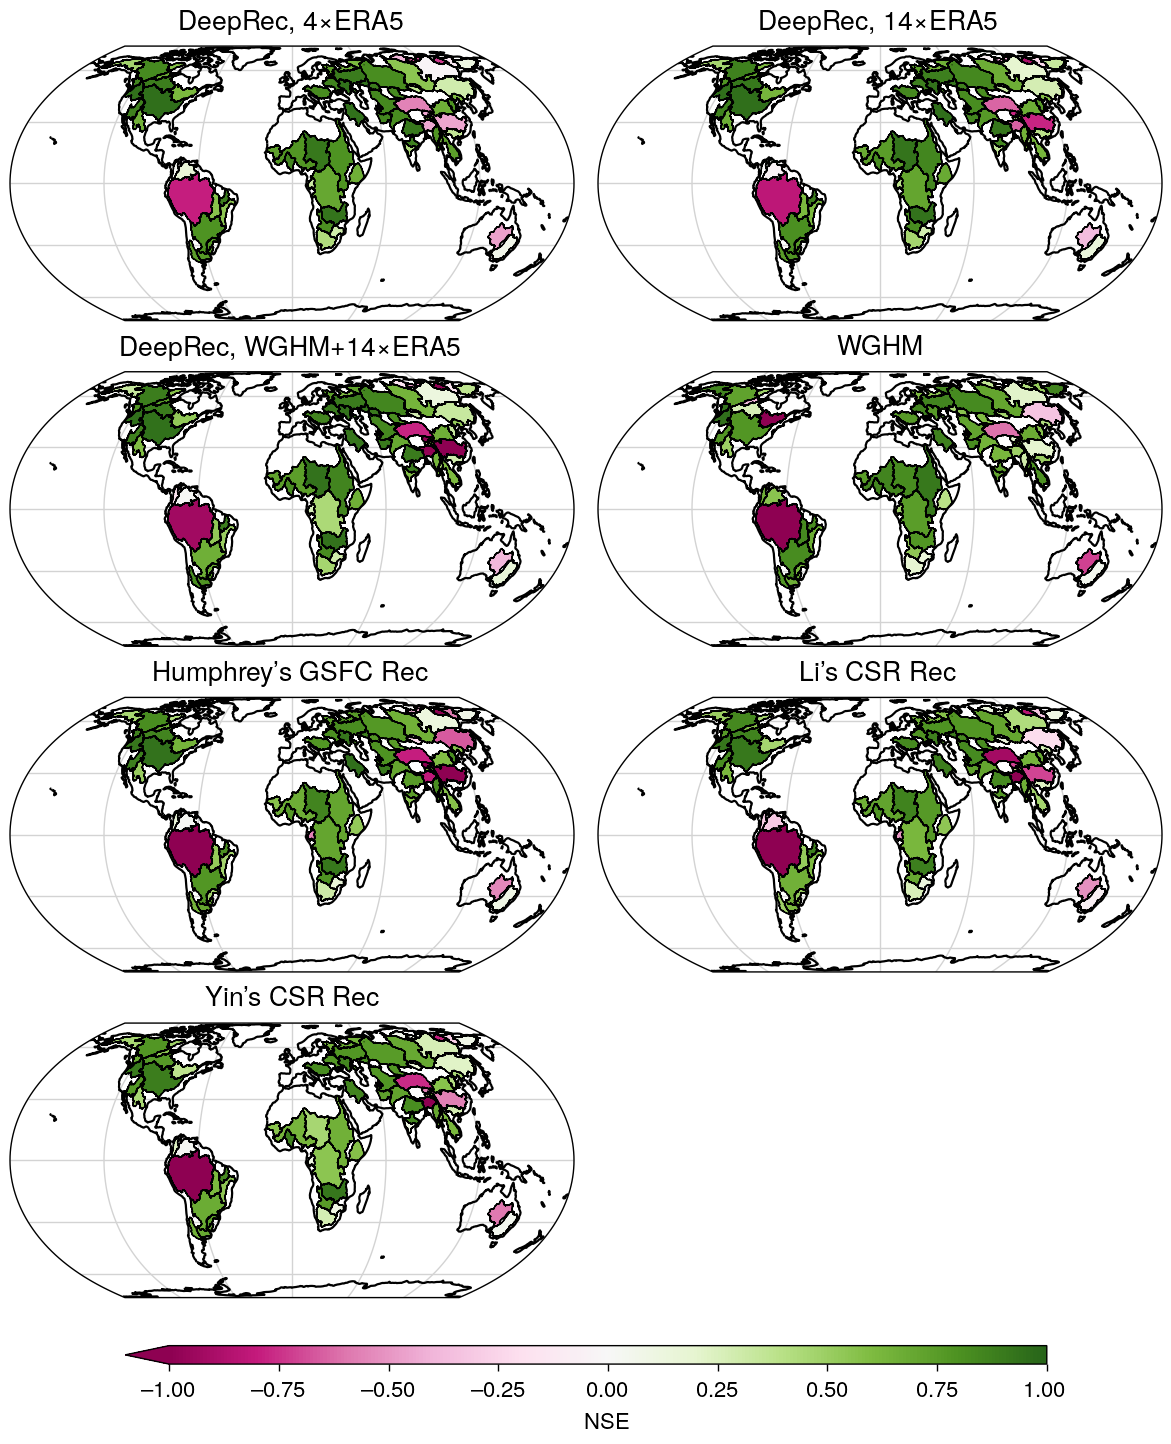

In [13]:
plot_kwargs["figsize"] = (6, 8.25)

p = da_pre_nse.dr.projplot_basins(
    spatial_obj=spatial_dummy_pre, col="model", **plot_kwargs
)

basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, da_pre_nse.model.values):
    basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)
    ax.set(title=vars_verbose[model])

p.fig.savefig(FIGURE_DIR / "waterbudget_1980-2002_nse.pdf", backend="pgf")